In [25]:
# Install gdown for auto-downloading from Google Drive
!pip install -q gdown

import gdown
import pandas as pd

# File ID extracted from your shared Google Drive link
file_id = "1BPY1TbmTGYZHP8K5vlAF9jAlRzz8HCL8"

# Download the CSV file from Google Drive and name it 'dataset.csv'
gdown.download(f"https://drive.google.com/uc?id={file_id}", "dataset.csv", quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1BPY1TbmTGYZHP8K5vlAF9jAlRzz8HCL8
To: /content/dataset.csv
100%|██████████| 1.60M/1.60M [00:00<00:00, 113MB/s]


'dataset.csv'

In [26]:
import pandas as pd


In [27]:
df = pd.read_csv("/content/dataset.csv")


In [28]:
def model1_price(occupancy, capacity, base_price=10, alpha=5):
    occ_ratio = occupancy / capacity if capacity != 0 else 0
    price = base_price + alpha * occ_ratio
    return round(min(max(price, 5), 20), 2)

In [29]:
print(df.columns)


Index(['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude',
       'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength',
       'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime'],
      dtype='object')


In [31]:
# Apply Model 1 pricing to the relevant columns
df["price_model1"] = df.apply(lambda row: model1_price(row["Occupancy"], row["Capacity"]), axis=1)


In [32]:
# Display selected columns
display(df[["SystemCodeNumber", "Occupancy", "Capacity", "price_model1"]].head())


,SystemCodeNumber,Occupancy,Capacity,price_model1
0,BHMBCCMKT01,61,577,10.53
1,BHMBCCMKT01,64,577,10.55
2,BHMBCCMKT01,80,577,10.69
3,BHMBCCMKT01,107,577,10.93
4,BHMBCCMKT01,150,577,11.30


In [33]:

df.to_csv("model1_output.csv", index=False)


In [35]:
df[["SystemCodeNumber", "Occupancy", "Capacity", "price_model1"]].head()

,SystemCodeNumber,Occupancy,Capacity,price_model1
0,BHMBCCMKT01,61,577,10.53
1,BHMBCCMKT01,64,577,10.55
2,BHMBCCMKT01,80,577,10.69
3,BHMBCCMKT01,107,577,10.93
4,BHMBCCMKT01,150,577,11.30


In [36]:
df.to_csv("model1_output.csv", index=False)


In [37]:
df[["SystemCodeNumber", "Occupancy", "Capacity", "price_model1"]].head()



,SystemCodeNumber,Occupancy,Capacity,price_model1
0,BHMBCCMKT01,61,577,10.53
1,BHMBCCMKT01,64,577,10.55
2,BHMBCCMKT01,80,577,10.69
3,BHMBCCMKT01,107,577,10.93
4,BHMBCCMKT01,150,577,11.30


In [38]:
!pip install -U pathway




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 7.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 

In [39]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/content/dataset.csv")

# Save it for Pathway streaming
df.to_csv("stream_input.csv", index=False)


In [40]:
import pathway as pw

# Pathway columns to expect
class ParkingDataSchema(pw.Schema):
    SystemCodeNumber: str
    Capacity: int
    Occupancy: int
    QueueLength: int


In [41]:
# stream that CSV into Pathway
input_table = pw.io.csv.read("stream_input.csv", schema=ParkingDataSchema)


In [42]:
# simple logic, like real life
def simple_price(queue, occ, cap):
    if queue > 5:
        return 20
    elif cap != 0 and occ > 0.8 * cap:
        return 18
    else:
        return 10

# wrap it for Pathway
@pw.udf
def compute_price(queue, occ, cap):
    return simple_price(queue, occ, cap)


In [43]:
# slap the price onto each row
output_table = input_table.with_columns(
    price = compute_price(
        input_table.QueueLength,
        input_table.Occupancy,
        input_table.Capacity
    )
)


In [44]:
# write it to a file so we can actually see something later
pw.io.csv.write(
    output_table.select(
        output_table.SystemCodeNumber,
        output_table.Occupancy,
        output_table.QueueLength,
        output_table.Capacity,
        output_table.price
    ),
    "stream_output.csv"
)


/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [45]:
# Define a new schema that includes all necessary columns from dataset.csv
class FullParkingDataSchema(pw.Schema):
    ID: int
    SystemCodeNumber: str
    Capacity: int
    Latitude: float
    Longitude: float
    Occupancy: int
    VehicleType: str
    TrafficConditionNearby: str
    QueueLength: int
    IsSpecialDay: int
    LastUpdatedDate: str
    LastUpdatedTime: str


In [46]:
# Read the dataset with the full schema
input_table = pw.io.csv.read(
    "dataset.csv",
    schema=FullParkingDataSchema,
    mode="static"
)


In [47]:
# Step 1: Define weights for each vehicle type
vehicle_type_weights = {
    "car": 1.0,
    "bike": 0.7,
    "truck": 1.5
}


In [48]:
# Step 2 (fixed for real): Manually create a static Pathway table with vehicle type weights
vehicle_type_lookup = pw.debug.table_from_markdown("""
key   | weight
car   | 1.0
bike  | 0.7
truck | 1.5
""")


In [49]:
# Correct way to inspect column names in a Pathway table
input_table.schema



<pathway.Schema types={'ID': <class 'int'>, 'SystemCodeNumber': <class 'str'>, 'Capacity': <class 'int'>, 'Latitude': <class 'float'>, 'Longitude': <class 'float'>, 'Occupancy': <class 'int'>, 'VehicleType': <class 'str'>, 'TrafficConditionNearby': <class 'str'>, 'QueueLength': <class 'int'>, 'IsSpecialDay': <class 'int'>, 'LastUpdatedDate': <class 'str'>, 'LastUpdatedTime': <class 'str'>}, id_type=<class 'pathway.engine.Pointer'>>

In [50]:
ParkingDataSchema.__annotations__



{'SystemCodeNumber': str,
 'Capacity': int,
 'Occupancy': int,
 'QueueLength': int}

In [51]:
# Step:3 Correct join using a comparison expression
input_with_weight = input_table.join(
    vehicle_type_lookup,
    input_table.VehicleType == vehicle_type_lookup.key
)



In [52]:
# Step 4: Use a UDF to calculate demand-based pricing safely
import numpy as np
import pathway as pw

# UDF to compute demand and final price based on given features
@pw.udf
def calculate_price(capacity, occupancy, queue_length, traffic_level, is_special_day, weight):
    # Linear demand formula
    demand = (
        1.0 * (occupancy / capacity) +
        0.5 * queue_length -
        0.3 * traffic_level +
        2.0 * is_special_day +
        1.0 * weight
    )

    # Normalize demand using sigmoid
    normalized = 1 / (1 + np.exp(-demand))

    # Final price calculation, scaled between 0.5x and 1.5x of $10
    price = 10 * (1 + 0.5 * (2 * normalized - 1))
    return price

# Apply the UDF to the input_with_weight table to get the final output
output_table = input_with_weight.select(
    parking_id = input_with_weight.SystemCodeNumber,
    timestamp = input_with_weight.LastUpdatedTime,
    price = calculate_price(
        input_with_weight.Capacity,
        input_with_weight.Occupancy,
        input_with_weight.QueueLength,
        input_with_weight.TrafficConditionNearby,
        input_with_weight.IsSpecialDay,
        input_with_weight.weight


    )
)


In [53]:
# Step 5 (fixed): Write output to a JSONL file
pw.io.jsonlines.write(output_table, "output.jsonl")


In [54]:
# Step 6: Run the Pathway pipeline
pw.run()


Output()

TypeError: can't multiply sequence by non-int of type 'float'

In [55]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("dataset.csv")

# Rename columns to match what we used in Pathway (optional for clarity)
df.rename(columns={
    "SystemCodeNumber": "parking_id",
    "QueueLength": "queue_length",
    "Occupancy": "occupancy",
    "Capacity": "capacity",
    "TrafficConditionNearby": "traffic_level",
    "VehicleType": "vehicle_type",
    "IsSpecialDay": "is_special_day"
}, inplace=True)

# Map vehicle type to weights
vehicle_type_weights = {
    "car": 1.0,
    "bike": 0.7,
    "truck": 1.5,
    "cycle": 0.3  # optional if you have this
}

df["vehicle_weight"] = df["vehicle_type"].map(vehicle_type_weights).fillna(1.0)  # default weight = 1.0

# Map traffic level to numeric (if it's in words)
traffic_map = {
    "low": 1,
    "average": 2,
    "high": 3
}
df["traffic_level"] = df["traffic_level"].map(traffic_map).fillna(2)

# Calculate demand
df["demand"] = (
    1.0 * (df["occupancy"] / df["capacity"]) +
    0.5 * df["queue_length"] -
    0.3 * df["traffic_level"] +
    2.0 * df["is_special_day"] +
    1.0 * df["vehicle_weight"]
)

# Normalize demand with sigmoid
df["normalized_demand"] = 1 / (1 + np.exp(-df["demand"]))

# Final price: 0.5x to 1.5x of $10
df["final_price"] = 10 * (1 + 0.5 * (2 * df["normalized_demand"] - 1))


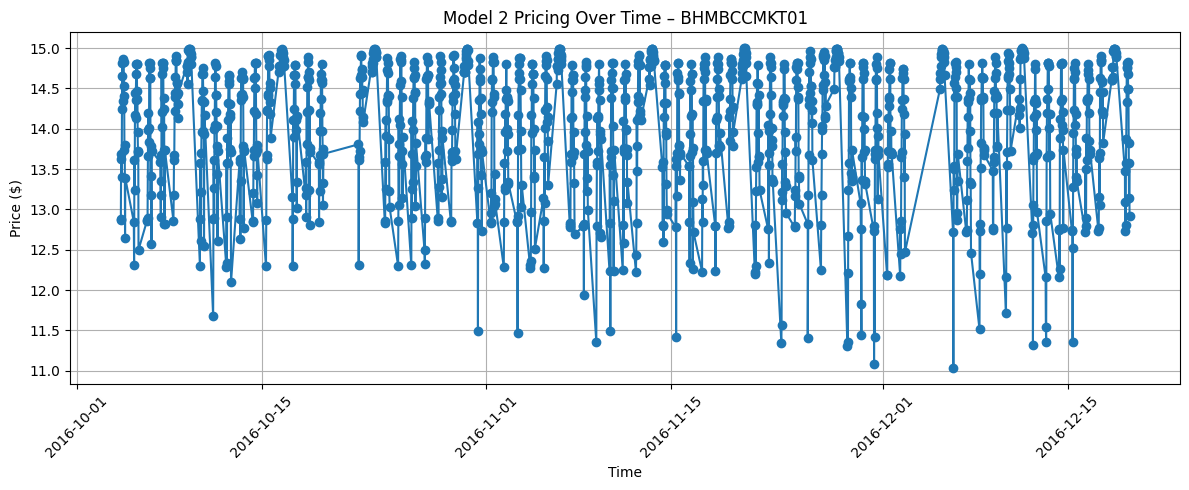

In [56]:
import matplotlib.pyplot as plt

# Combine date and time into timestamp
df["timestamp"] = pd.to_datetime(df["LastUpdatedDate"] + " " + df["LastUpdatedTime"], dayfirst=True)


# Filter for one parking lot (replace with any ID from your dataset)
lot_df = df[df["parking_id"] == "BHMBCCMKT01"]

# Sort by time so the plot looks clean
lot_df = lot_df.sort_values("timestamp")

# Plot price over time
plt.figure(figsize=(12, 5))
plt.plot(lot_df["timestamp"], lot_df["final_price"], marker='o', linestyle='-')
plt.title("Model 2 Pricing Over Time – BHMBCCMKT01")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
df["model1_price"] = 10 + 5 * (df["occupancy"] / df["capacity"])


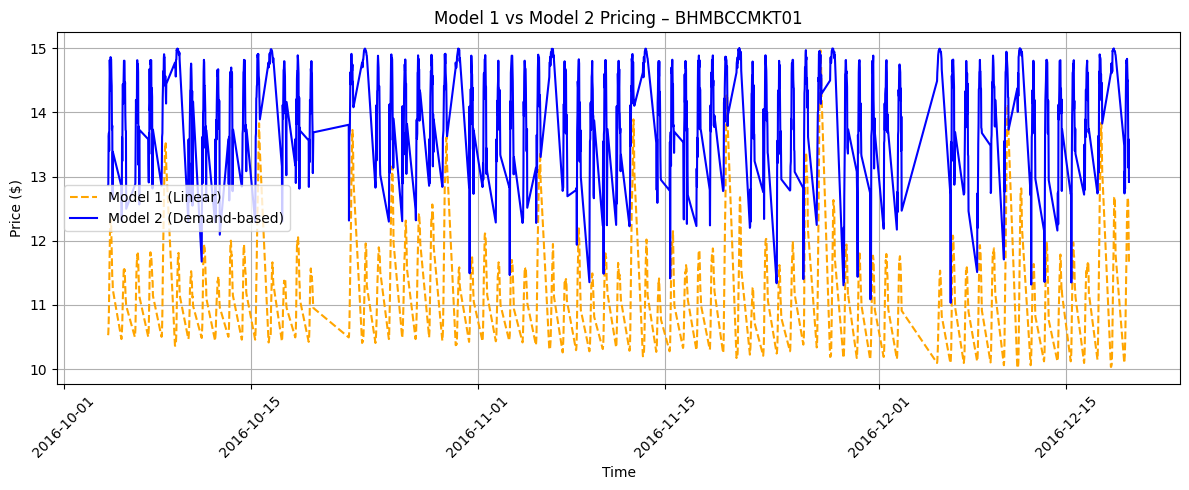

In [58]:
lot_df = df[df["parking_id"] == "BHMBCCMKT01"].sort_values("timestamp")

plt.figure(figsize=(12, 5))
plt.plot(lot_df["timestamp"], lot_df["model1_price"], label="Model 1 (Linear)", linestyle="--", color="orange")
plt.plot(lot_df["timestamp"], lot_df["final_price"], label="Model 2 (Demand-based)", color="blue")
plt.title("Model 1 vs Model 2 Pricing – BHMBCCMKT01")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


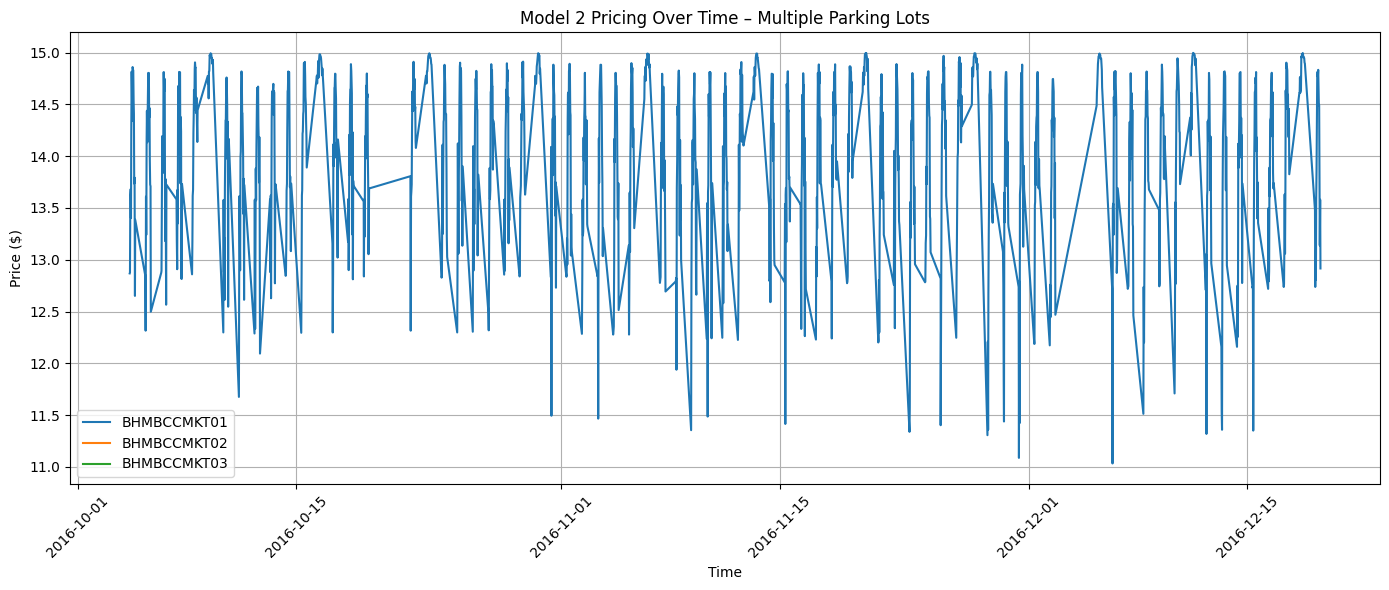

In [59]:
plt.figure(figsize=(14, 6))

# Choose a few parking IDs (replace with any from your data)
selected_ids = ["BHMBCCMKT01", "BHMBCCMKT02", "BHMBCCMKT03"]

for pid in selected_ids:
    lot_df = df[df["parking_id"] == pid].sort_values("timestamp")
    plt.plot(lot_df["timestamp"], lot_df["final_price"], label=pid)

plt.title("Model 2 Pricing Over Time – Multiple Parking Lots")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [60]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
import pandas as pd

# Enable Bokeh inside the notebook
output_notebook()

# Filter one parking lot (change ID if you want)
lot_df = df[df["parking_id"] == "BHMBCCMKT01"].copy()
lot_df = lot_df.sort_values("timestamp")

# Create a Bokeh data source
source = ColumnDataSource(data={
    "time": lot_df["timestamp"],
    "price": lot_df["final_price"],
    "vehicle_type": lot_df["vehicle_type"],
    "queue": lot_df["queue_length"],
    "traffic": lot_df["traffic_level"]
})

# Create the figure
p = figure(x_axis_type="datetime", title="Model 2 Pricing – BHMBCCMKT01",
           height=400, width=800, tools="pan,wheel_zoom,box_zoom,reset,hover,save")

# Add a line
p.line(x="time", y="price", source=source, line_width=2, color="navy", legend_label="Price")

# Configure tooltips
hover = p.select(dict(type=HoverTool))
hover.tooltips = [
    ("Time", "@time{%F %T}"),
    ("Price", "@price{$0.00}"),
    ("Vehicle", "@vehicle_type"),
    ("Queue", "@queue"),
    ("Traffic", "@traffic")
]
hover.formatters = {"@time": "datetime"}

p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Price ($)"
p.legend.location = "top_left"

# Show the plot
show(p)
